# Single-cell Analysis Workflow: 1.3M brain cells example
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working RAPIDS environment with all necessary dependencies. In this example workflow we'll be looking at a dataset of 1.3M brain cells from [10X Genomics](https://www.10xgenomics.com/datasets/1-3-million-brain-cells-from-e-18-mice-2-standard-1-3-0).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
import gc

## Load and Prepare Data

Let's start by ensuring that we have our dataset downloaded.

In [4]:
import wget
import os
from anndata.experimental import read_elem_lazy
import h5py

url = 'https://exampledata.scverse.org/rapids-singlecell/1M_brain_cells_10X.sparse.h5ad'
data_dir = "./h5"
final = data_dir+'/nvidia_1.3M.h5ad'

if not os.path.exists(data_dir): # Check if h5 directory exists
    print('creating data directory')
    os.system('mkdir ./h5')
else:
    print(f'{data_dir} directory found')

if not os.path.isfile(final): # Check to see if we have our final output.  If it is there, get to the analysis!
    print(f'Downloading cell data into {final}...')
    os.system(f"wget {url} -O {final}")
else:
    print(f'{final} dataset found')

./h5 directory found
./h5/nvidia_1.3M.h5ad dataset found


We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [5]:
data_load_start = time.time()

In [6]:
%%time
adata = sc.read(final)
adata.var_names_make_unique()
adata = adata[:1_000_000, :].copy()

CPU times: user 44 s, sys: 6.6 s, total: 50.6 s
Wall time: 50.6 s


We now load the the AnnData object into VRAM.

In [7]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 691 ms, sys: 2.37 s, total: 3.06 s
Wall time: 3.06 s


Verify the shape of the resulting sparse matrix:

In [8]:
adata.shape

(1000000, 27998)

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 53.70169496536255


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="mt-")

CPU times: user 2.11 ms, sys: 19 μs, total: 2.13 ms
Wall time: 2.09 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT"])

CPU times: user 306 ms, sys: 4.14 ms, total: 310 ms
Wall time: 309 ms


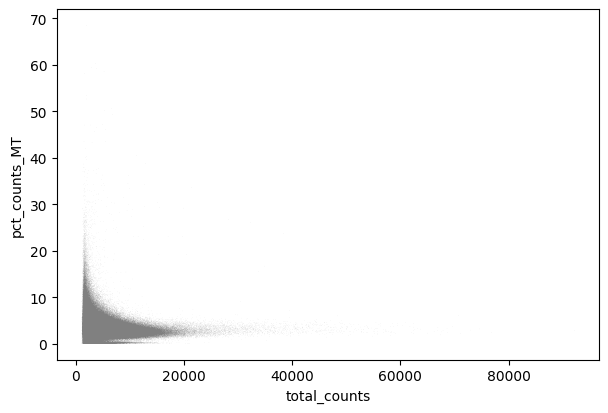

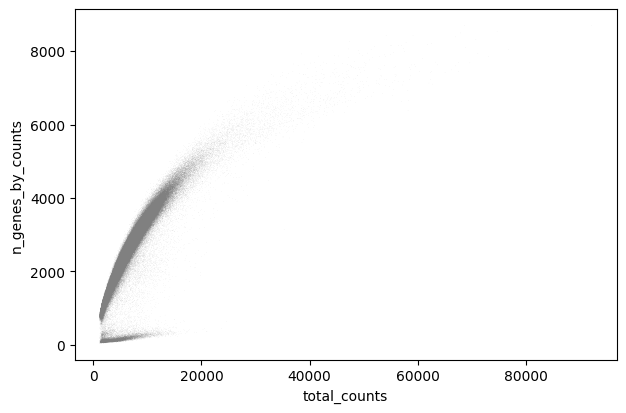

CPU times: user 2.88 s, sys: 36.9 ms, total: 2.92 s
Wall time: 2.92 s


In [13]:
%%time
sc.pl.scatter(adata, "total_counts", "pct_counts_MT")
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts")

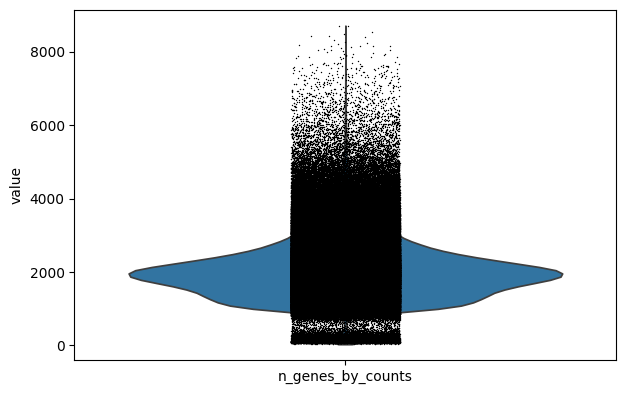

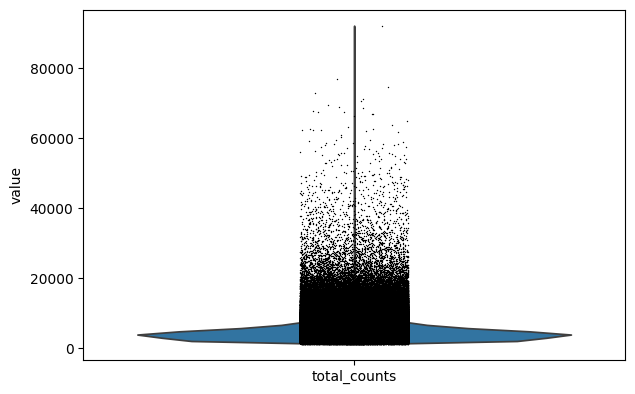

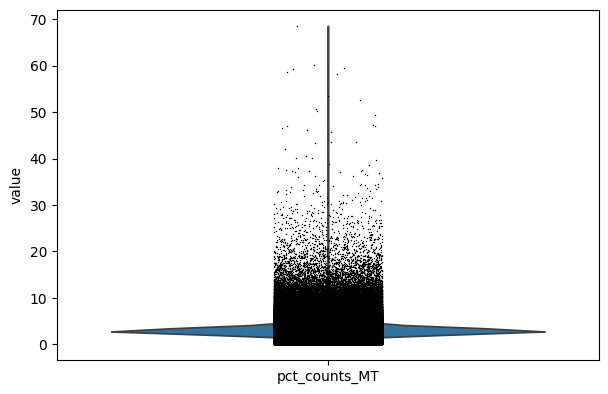

CPU times: user 27.7 s, sys: 71.1 ms, total: 27.8 s
Wall time: 6.91 s


In [14]:
%%time
sc.pl.violin(adata, keys="n_genes_by_counts")
sc.pl.violin(adata, keys="total_counts")
sc.pl.violin(adata, keys="pct_counts_MT")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [15]:
%%time
adata = adata[
    (adata.obs["n_genes_by_counts"] < 5000)
    & (adata.obs["n_genes_by_counts"] > 500)
    & (adata.obs["pct_counts_MT"] < 20)
].copy()

CPU times: user 169 ms, sys: 4 ms, total: 173 ms
Wall time: 172 ms


Many python objects are not deallocated until garbage collection runs. When working with data that barely fits in memory (generally, >50%) you may need to manually trigger garbage collection to reclaim memory.

In [16]:
%%time
gc.collect()

CPU times: user 144 ms, sys: 154 μs, total: 144 ms
Wall time: 144 ms


3673

We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
rsc.pp.filter_genes(adata, min_cells=3)

filtered out 5459 genes that are detected in less than 3 cells
CPU times: user 278 ms, sys: 2.06 ms, total: 280 ms
Wall time: 279 ms


We store the raw expression counts in the `.layer["counts"]`

In [18]:
adata.layers["counts"] = adata.X.copy()

In [19]:
adata.shape

(982490, 22539)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 862 μs, sys: 0 ns, total: 862 μs
Wall time: 868 μs


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(adata)

CPU times: user 21.8 ms, sys: 2.05 ms, total: 23.8 ms
Wall time: 23.6 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`. 

In [22]:
%%time
rsc.pp.highly_variable_genes(
    adata, n_top_genes=5000, flavor="seurat_v3", layer="counts"
)

CPU times: user 232 ms, sys: 4.08 ms, total: 236 ms
Wall time: 235 ms


In [23]:
%%time
rsc.get.anndata_to_CPU(adata, layer="counts")

CPU times: user 556 ms, sys: 588 ms, total: 1.14 s
Wall time: 1.14 s


Now we safe this version of the AnnData as adata.raw.

In [24]:
%%time
adata.raw = adata

CPU times: user 565 ms, sys: 573 ms, total: 1.14 s
Wall time: 1.14 s


Now we restrict our AnnData object to the highly variable genes.

In [25]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 640 ms, sys: 583 ms, total: 1.22 s
Wall time: 1.22 s


In [26]:
adata.shape

(982490, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [27]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 6.49 s, sys: 882 ms, total: 7.37 s
Wall time: 7.37 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [28]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 180 ms, sys: 13 ms, total: 193 ms
Wall time: 192 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuml to run this. With `use_highly_variable = False` we save VRAM since we already subset the matrix to only HVGs.

In [29]:
%%time
rsc.pp.pca(adata, n_comps=100, use_highly_variable=False)

CPU times: user 1.47 s, sys: 118 ms, total: 1.59 s
Wall time: 1.59 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

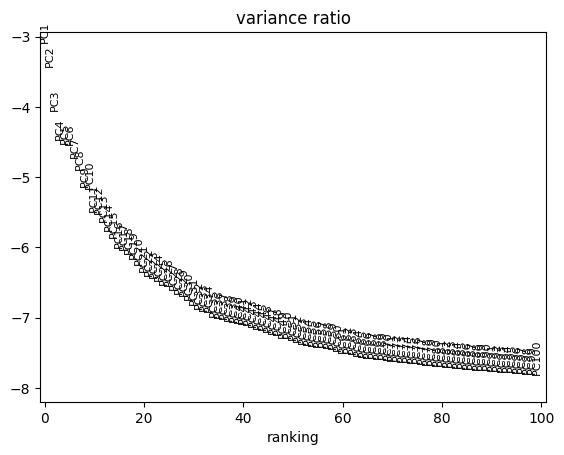

In [30]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [31]:
%%time
rsc.get.anndata_to_CPU(adata)

CPU times: user 749 ms, sys: 652 ms, total: 1.4 s
Wall time: 1.4 s


In [32]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 25.24337911605835


## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [33]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

CPU times: user 5.02 s, sys: 3.49 s, total: 8.51 s
Wall time: 8.5 s


Next we calculate the UMAP embedding using rapdis.

In [34]:
%%time
rsc.tl.umap(adata, min_dist=0.3)

CPU times: user 953 ms, sys: 128 ms, total: 1.08 s
Wall time: 1.08 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [35]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 1.75 s, sys: 151 ms, total: 1.9 s
Wall time: 1.91 s


In [36]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 1.13 s, sys: 53.3 ms, total: 1.19 s
Wall time: 1.18 s


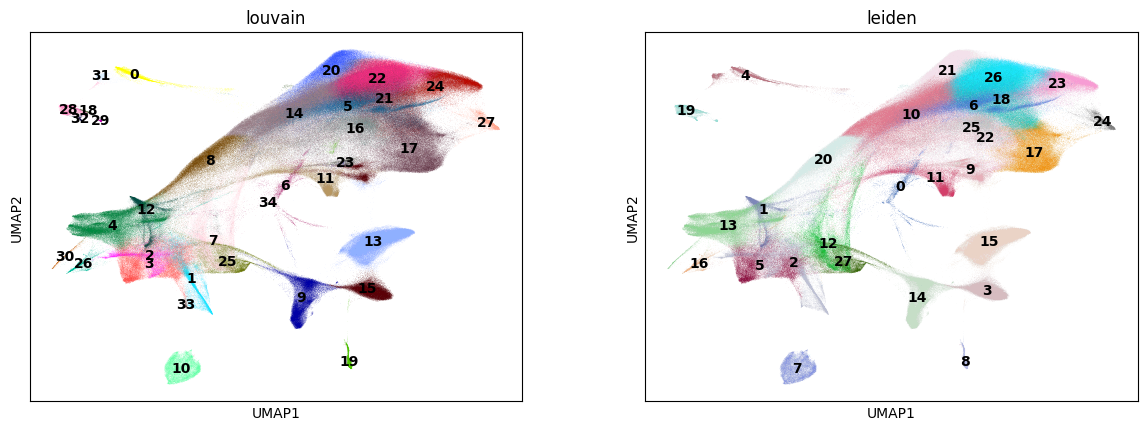

CPU times: user 3.6 s, sys: 27.2 ms, total: 3.63 s
Wall time: 3.63 s


In [37]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

## TSNE

In [38]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[2026-02-22 22:06:13.410] [CUML] [warning] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 7.6 s, sys: 9.02 s, total: 16.6 s
Wall time: 16.6 s


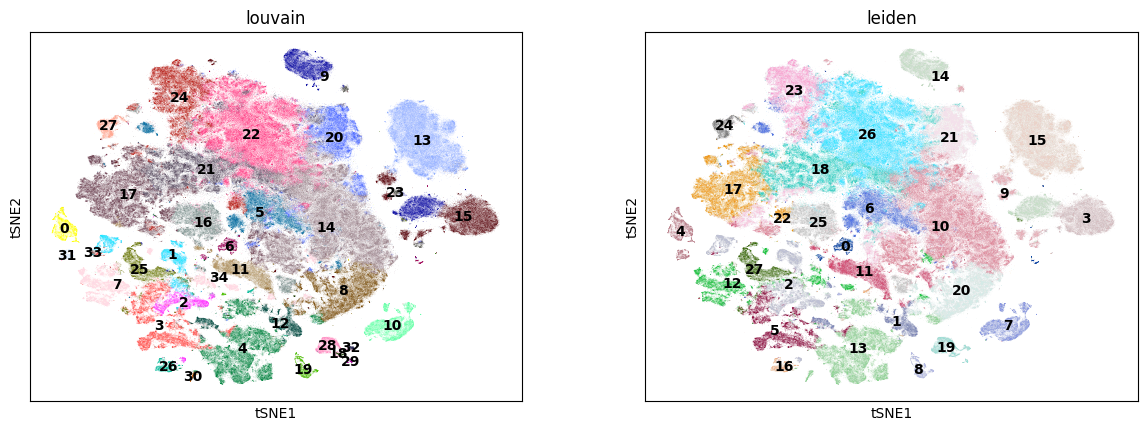

In [39]:
sc.pl.tsne(adata, color=["louvain", "leiden"], legend_loc="on data")

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvaincluster.

In [43]:
%%time
rsc.tl.rank_genes_groups(adata, groupby="leiden", method="logreg", use_raw=False)

[2026-02-22 22:08:53.998] [CUML] [warning] L-BFGS: max iterations reached
[2026-02-22 22:08:53.998] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
CPU times: user 24.8 s, sys: 7.85 s, total: 32.6 s
Wall time: 32.6 s


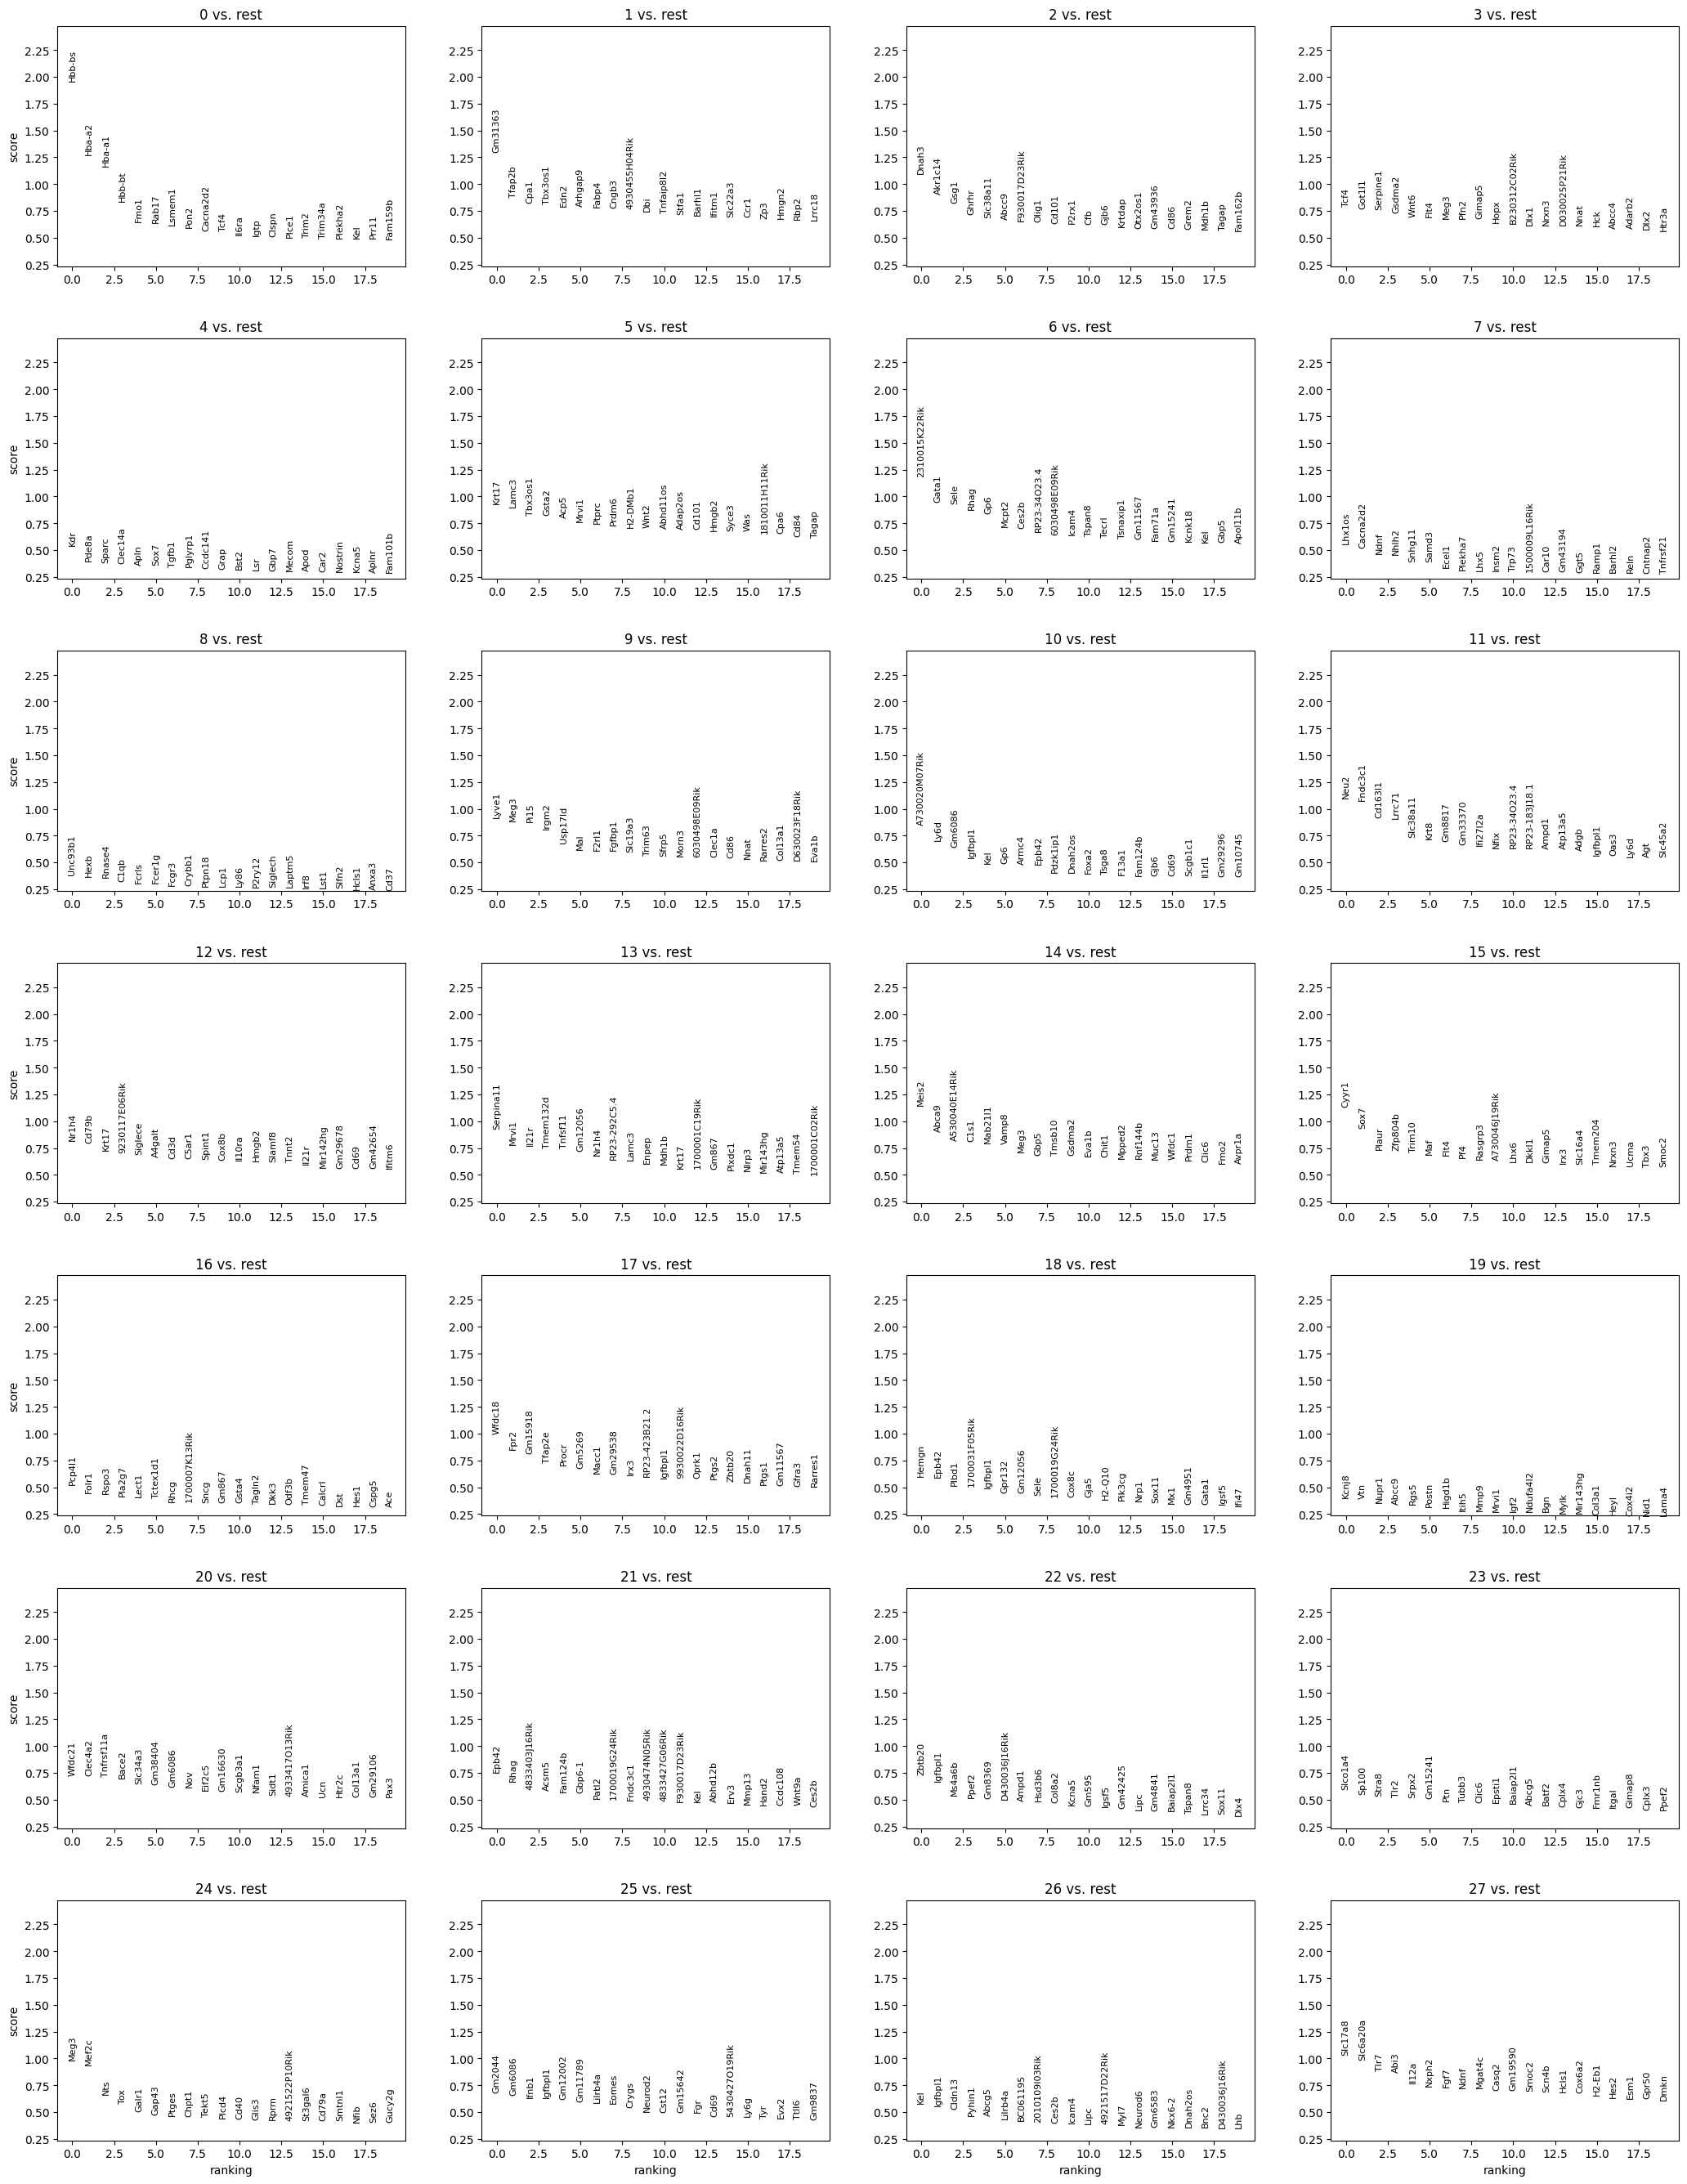

CPU times: user 1.31 s, sys: 13.8 ms, total: 1.33 s
Wall time: 1.33 s


In [44]:
%%time
sc.pl.rank_genes_groups(adata)

## Diffusion Maps

In [45]:
%%time
rsc.tl.diffmap(adata)
adata.obsm["X_diffmap"] = adata.obsm["X_diffmap"][:, 1:]

CPU times: user 1.91 s, sys: 0 ns, total: 1.91 s
Wall time: 1.91 s


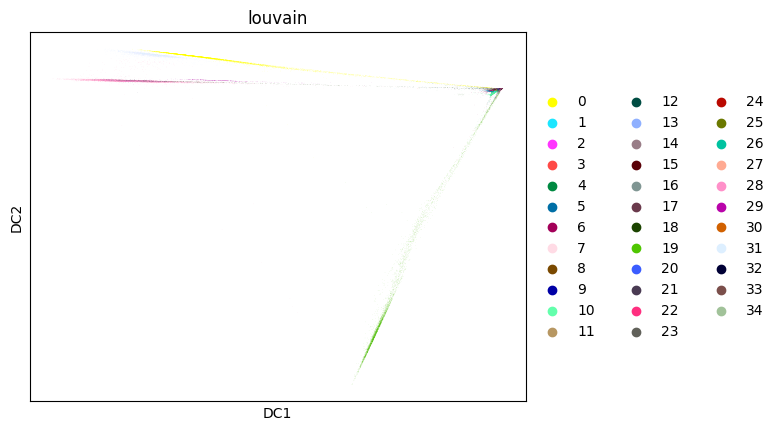

In [46]:
sc.pl.diffmap(adata, color="louvain")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [47]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 207.69249773025513


In [48]:
# These notebooks are very GPU memory intensive!
# In order to free up GPU memory, we'll kill this kernel prior to proceeding.  You will get a message.  This is expected.
# If you have a CUDA or an Out Of Memory (OOM) error, please kill all kernels to free up your GPU memory and try again!
# You can comment this out if you want to continue exploring the notebook.
# Please consult the README for more tips and tricks.

import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}